<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Aging/AgingCountersTestStandUVaBottom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init and load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import numpy.polynomial.polynomial as poly
import numpy as np
import scipy
from scipy.optimize import curve_fit
import statistics
import math
from datetime import datetime, timedelta
plt.rcParams.update({'figure.max_open_warning': 0})
import itertools as it

MIN_TEMP=21
MAX_TEMP=22
TIME_INDEX_CUT=2020

CS137_DECAY_RATE=0.023 # 2.3%/year

In [2]:
!pip install gdown
!gdown https://drive.google.com/uc?id=17Yjr34rnNR0GOWfxkGhcwCjZwhnOrDCT

Downloading...
From: https://drive.google.com/uc?id=17Yjr34rnNR0GOWfxkGhcwCjZwhnOrDCT
To: /content/ScanningData_NaturalAgingBottom.txt
100% 5.26M/5.26M [00:00<00:00, 82.7MB/s]


In [3]:
filename = 'ScanningData_NaturalAgingBottom.txt'
with open(filename) as f:
  rows = f.readlines()
  cols = [i for i in range(len(rows[len(rows) - 1].split()))] #this reads the length of the last line and uses that as the number of columns so you don't have to count the number
  data = pd.read_csv(filename, names=cols, sep="\t", header=None, engine='python')
  data[1] = pd.to_datetime(data[1])
  data.set_index(1, inplace=True)

In [4]:
data = data[data.iloc[:, 3:70].gt(0).all(axis=1)]
data.index.names = ['date']
data.drop(0, axis=1, inplace=True)
data.rename({2: 'source'}, axis=1, inplace=True)

column_renames_dict = {}
for col in data.columns[1:].values:
  column_renames_dict[col] = col-3
data.rename(columns=column_renames_dict, inplace=True)
data = data.reset_index()

data.rename({67: 'temp'}, axis=1, inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [5]:
data_signal = data.query('source==1')
data_pedest = data.query('source==0')

In [6]:
data_pedest.median()[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


0.1428

In [7]:
def funcC(x, a, b, c): #this is an exponential plus a constant
    return a * np.exp(-b * x) + c
def expo(x, a, b): #this is an exponential
    return a * np.exp(-b * x)
def lin_func(x, a, b): #a linear function
    return a + b * x
def pol0(x, a): #a straight line function
    return a 
def pol2(x, a, b, c): #a second order polynomial
  return (a*x**2) + b*x + c
pd.set_option('max_columns', None)

def getChanLabel(chan):
  label=''
  if chan>=0 and chan<4:
    label='Fresh: Extrusions'
  if chan>=4 and chan<8:
    label='Fresh: Uncured'
  if chan>=8 and chan<12:
    label='Old: Extrusions'
  if chan>=16 and chan<20:
    label='Old: Assembled'
  if chan>=60 and chan<64:
    label='Old: Uncured'
  return label

#Make plots

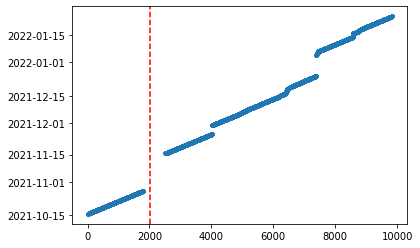

In [8]:
plt.plot(data_signal.index, data_signal.date, '.')
plt.axvline(x=TIME_INDEX_CUT, ls='--', c='r')

In [9]:
pd.options.mode.chained_assignment = None 
data_ = data_signal.loc[ (data_signal.temp>MIN_TEMP) & (data_signal.temp<MAX_TEMP)  & (data_signal.index>TIME_INDEX_CUT)]
X = (data_.date -  data_.date.to_numpy()[0]).astype('timedelta64[h]')/(365*24) #divides days into years

for chan in it.chain(range(0, 12), range(16, 20), range(60,64)):
  pedestal = data_pedest.median()[chan] # FIXME
  data_[chan] = data_[chan] - pedestal #subtracts the pedestal value
  max_current = data_[chan][0:100].mean() 
  data_[chan] = data_[chan]/max_current#normalizing

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


<Figure size 432x288 with 0 Axes>

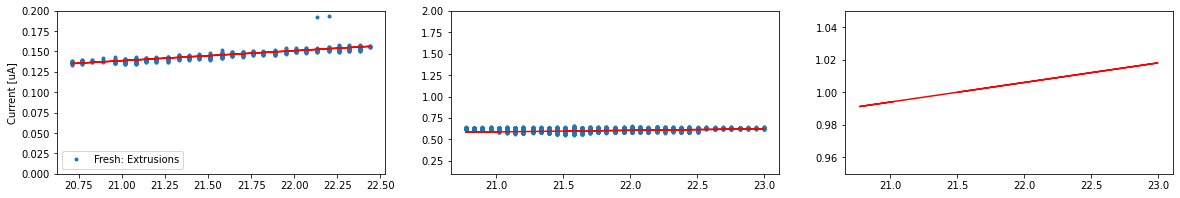

<Figure size 432x288 with 0 Axes>

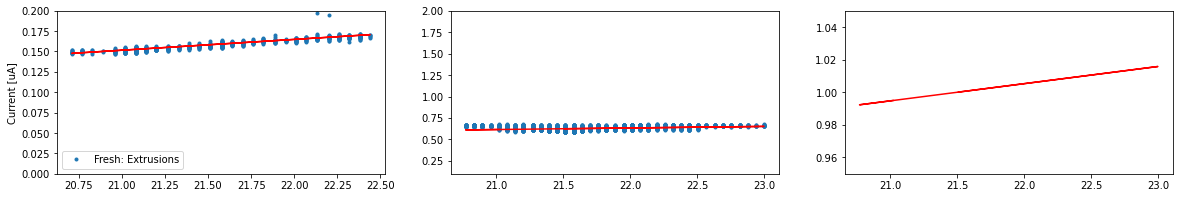

<Figure size 432x288 with 0 Axes>

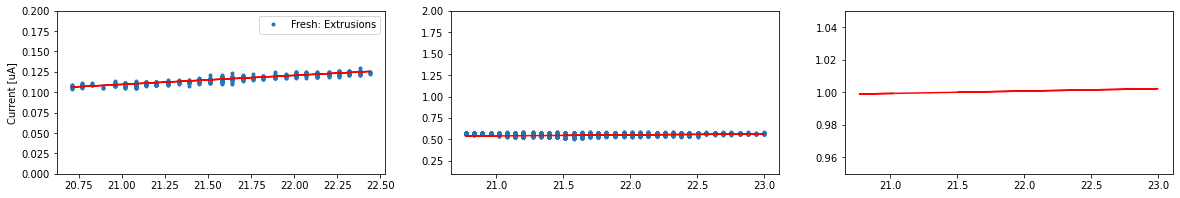

<Figure size 432x288 with 0 Axes>

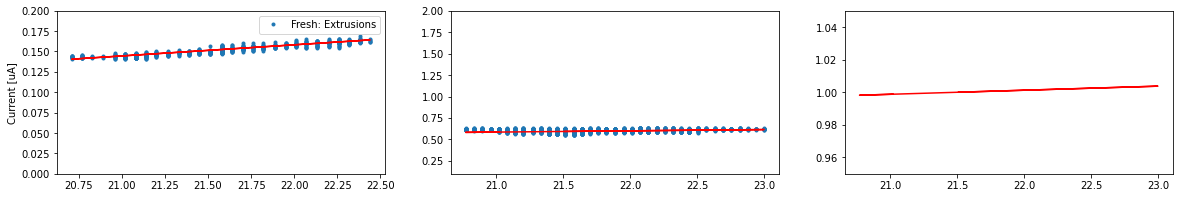

<Figure size 432x288 with 0 Axes>

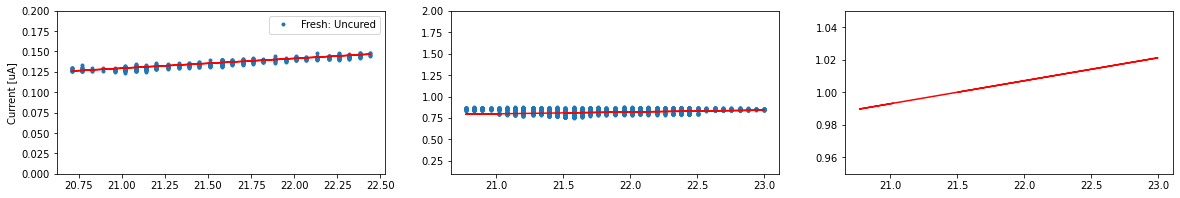

<Figure size 432x288 with 0 Axes>

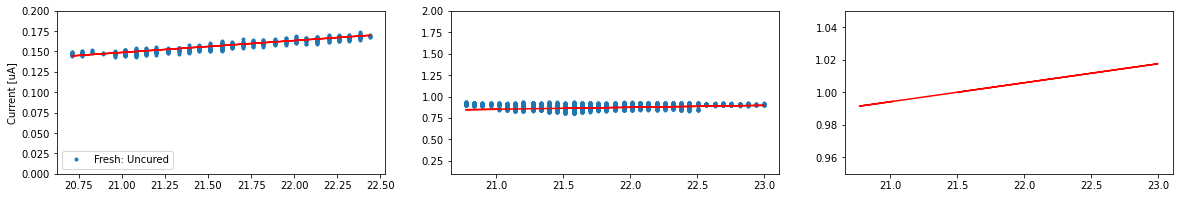

<Figure size 432x288 with 0 Axes>

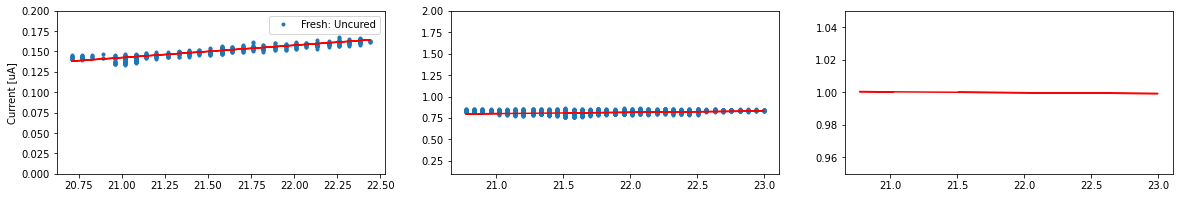

<Figure size 432x288 with 0 Axes>

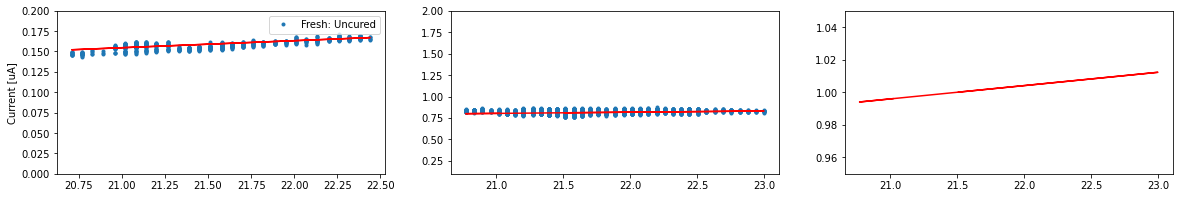

<Figure size 432x288 with 0 Axes>

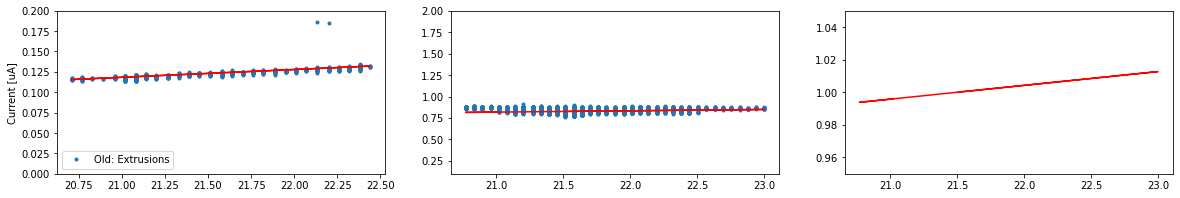

<Figure size 432x288 with 0 Axes>

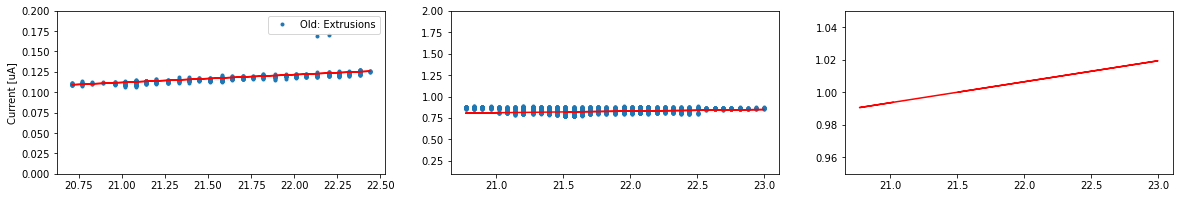

<Figure size 432x288 with 0 Axes>

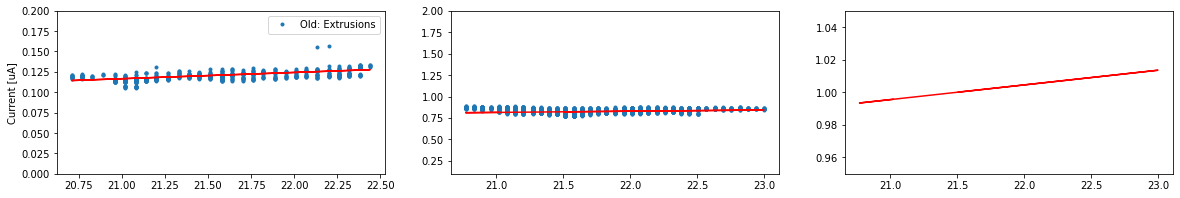

<Figure size 432x288 with 0 Axes>

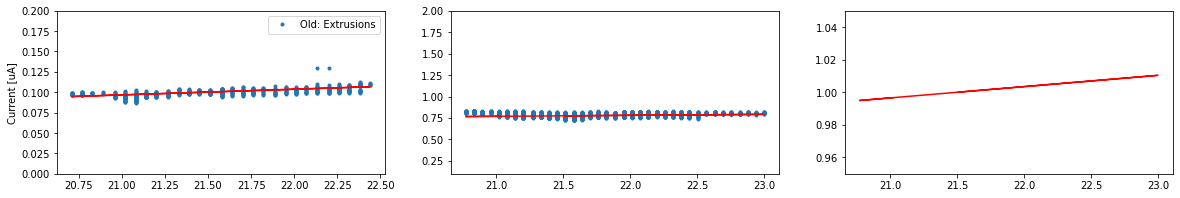

<Figure size 432x288 with 0 Axes>

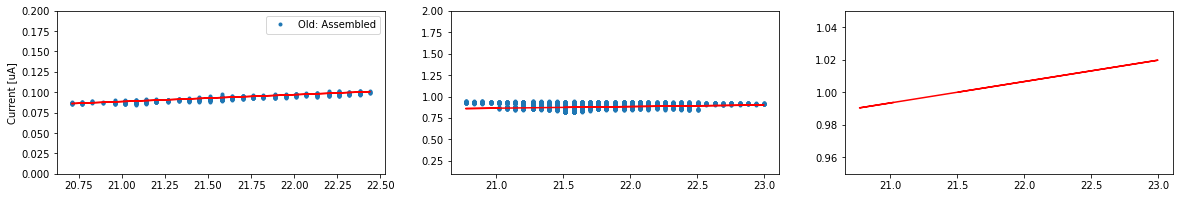

<Figure size 432x288 with 0 Axes>

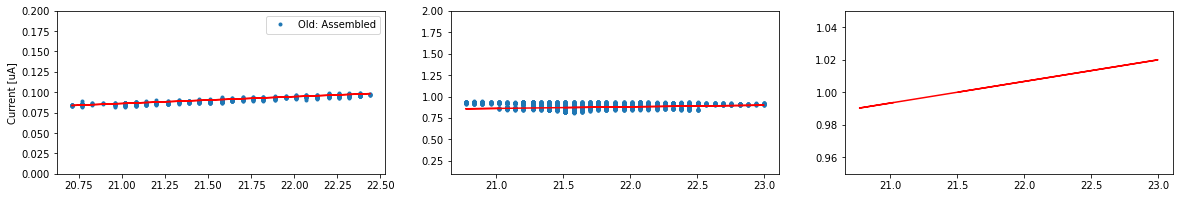

<Figure size 432x288 with 0 Axes>

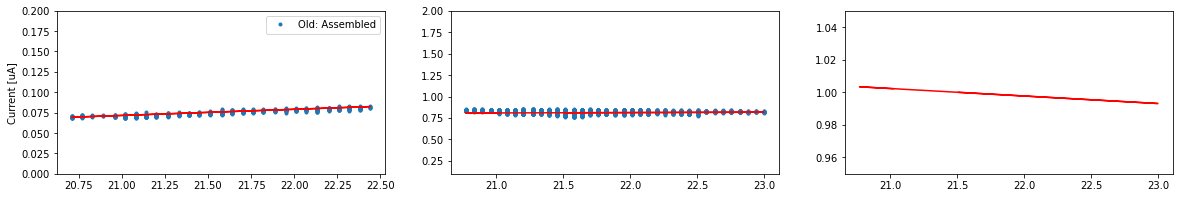

<Figure size 432x288 with 0 Axes>

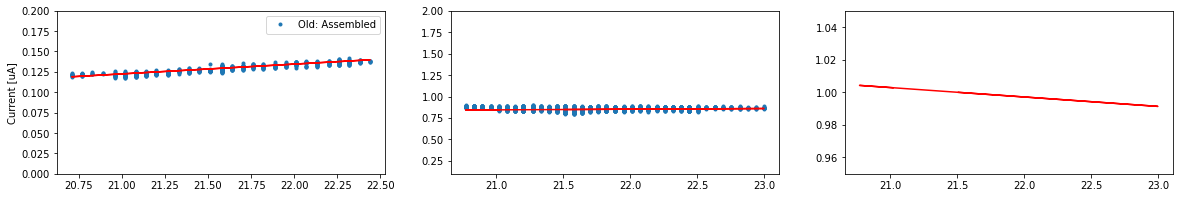

<Figure size 432x288 with 0 Axes>

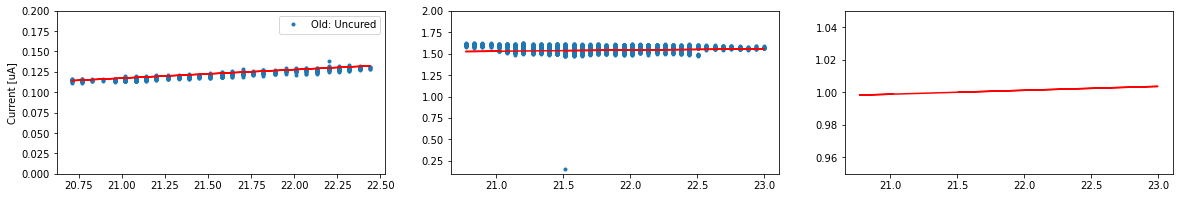

<Figure size 432x288 with 0 Axes>

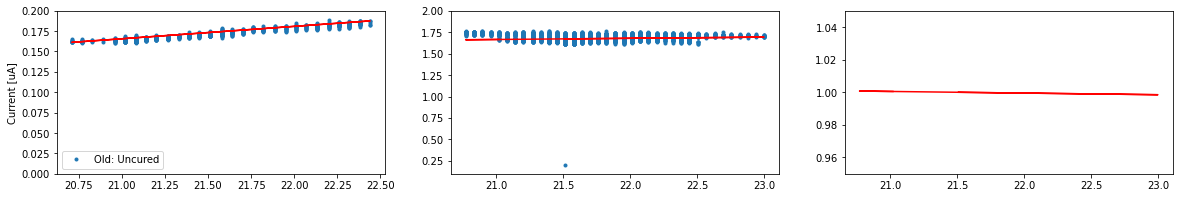

<Figure size 432x288 with 0 Axes>

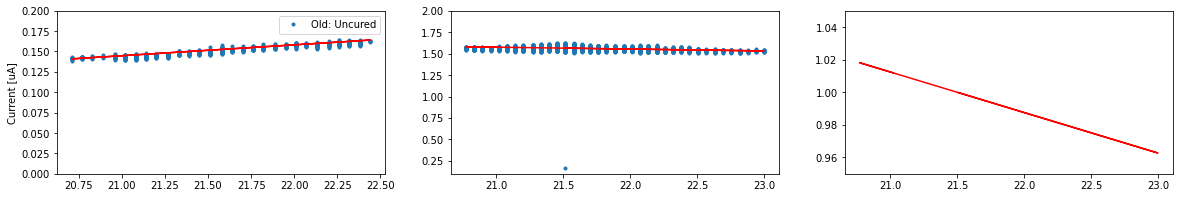

<Figure size 432x288 with 0 Axes>

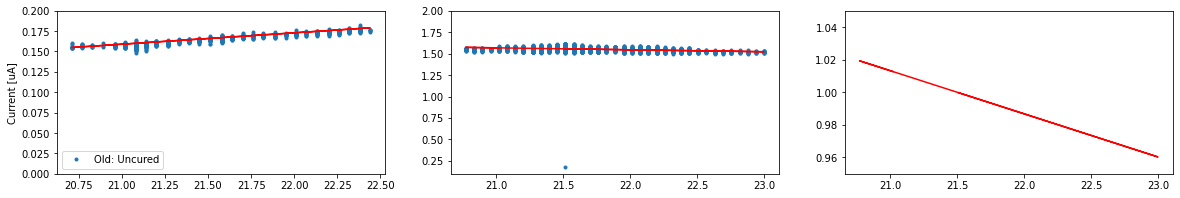

In [10]:
calib_df = pd.DataFrame()

for chan in it.chain(range(0, 12), range(16, 20), range(60,64)):
  plt.figure()

  if chan>=0 and chan<4:
    label='Fresh: Extrusions'
  if chan>=4 and chan<8:
    label='Fresh: Uncured'
  if chan>=8 and chan<12:
    label='Old: Extrusions'
  if chan>=16 and chan<20:
    label='Old: Assembled'
  if chan>=60 and chan<64:
    label='Old: Uncured'

  fig, axs = plt.subplots(1,3, figsize=(20, 3));

  axs[0].plot(data_pedest.temp, data_pedest[chan], '.', label=label);
  popt_ped, pcov = curve_fit(lin_func, data_pedest.temp, data_pedest[chan], p0=(1, 0.05))
  axs[0].plot(data_pedest.temp, lin_func(data_pedest.temp, *popt_ped), 'r-')
  axs[0].set_ylabel('Current [uA]')
  axs[0].set_ylim(0.0, 0.2)
  axs[0].legend()

  axs[1].plot(data_signal.temp, data_signal[chan], '.', label=label);
  popt_sig, pcov = curve_fit(lin_func, data_signal.temp, data_signal[chan], p0=(1, 0.05))
  axs[1].plot(data_signal.temp, lin_func(data_signal.temp, *popt_sig), 'r-')
  axs[1].set_ylim(0.1, 2.)

  FIXED_TEMP = (MAX_TEMP+MIN_TEMP)/2
  SIG_AT_FIXED_TEMP = lin_func(FIXED_TEMP, *(popt_sig-popt_ped))
  axs[2].plot(data_signal.temp, lin_func(data_signal.temp, *(popt_sig-popt_ped))/SIG_AT_FIXED_TEMP, 'r-', label=label)
  axs[2].set_ylim(0.95, 1.05)
  calib_df = calib_df.append({'chan': chan,'name': label, 'const': (popt_sig-popt_ped)[0]/SIG_AT_FIXED_TEMP, 'slope': (popt_sig-popt_ped)[1]/SIG_AT_FIXED_TEMP}, ignore_index=True)

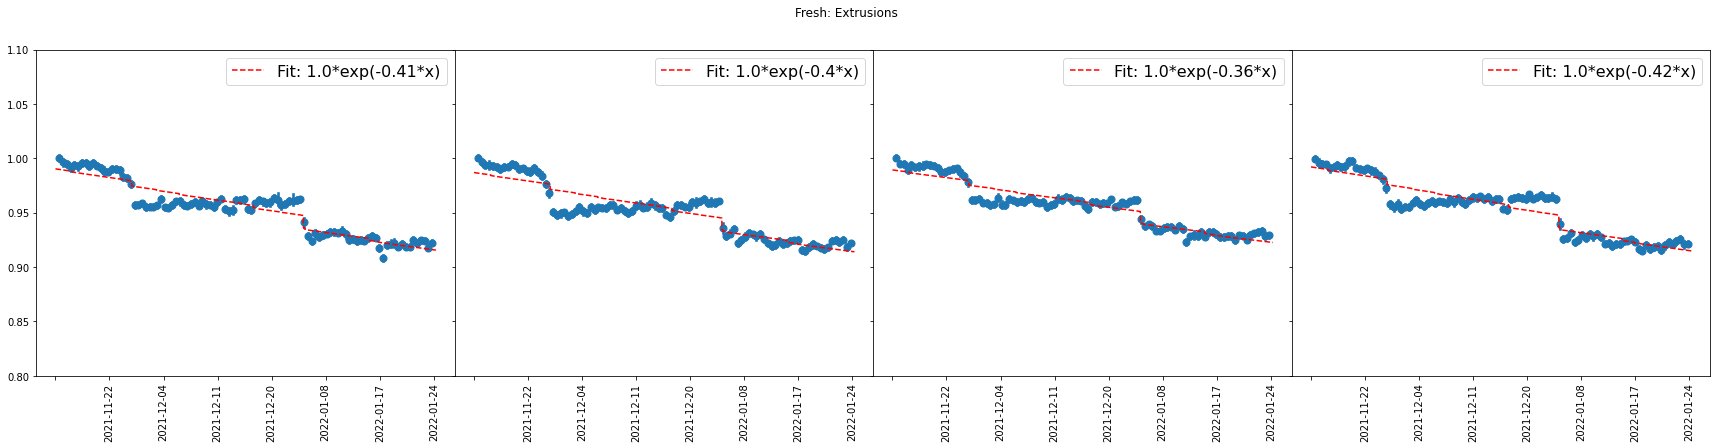

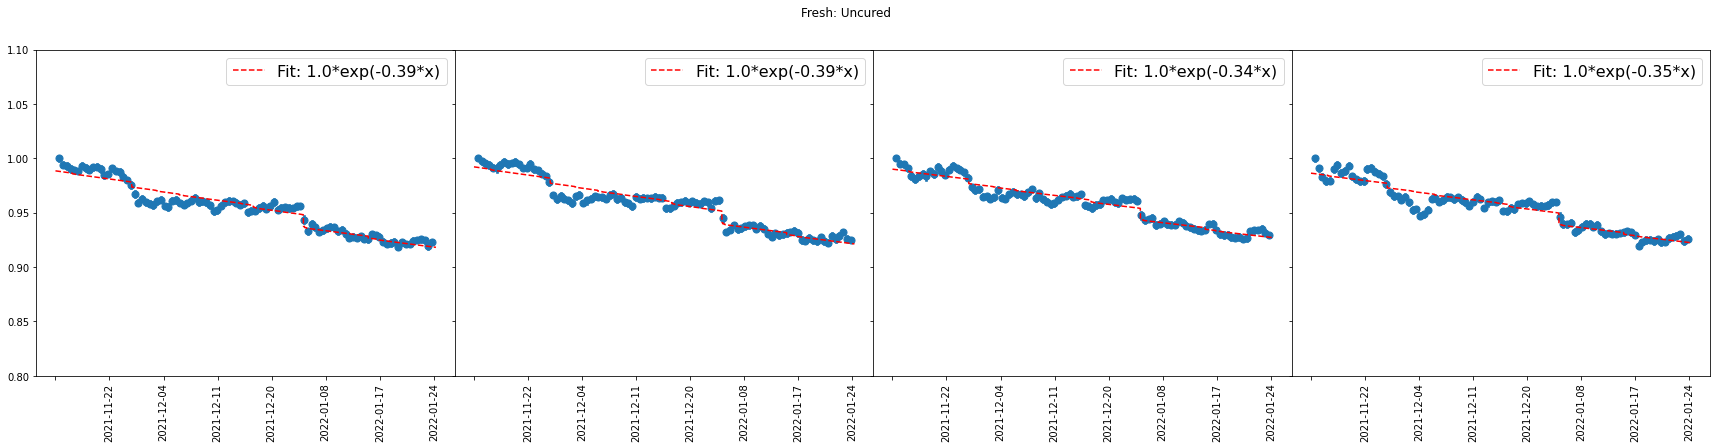

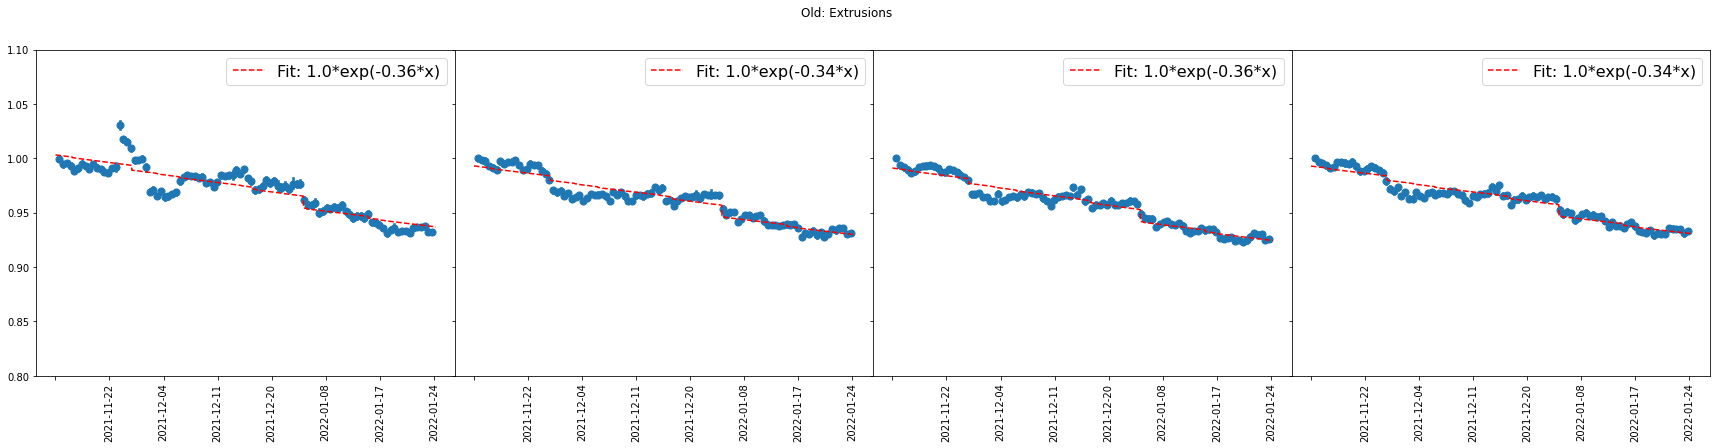

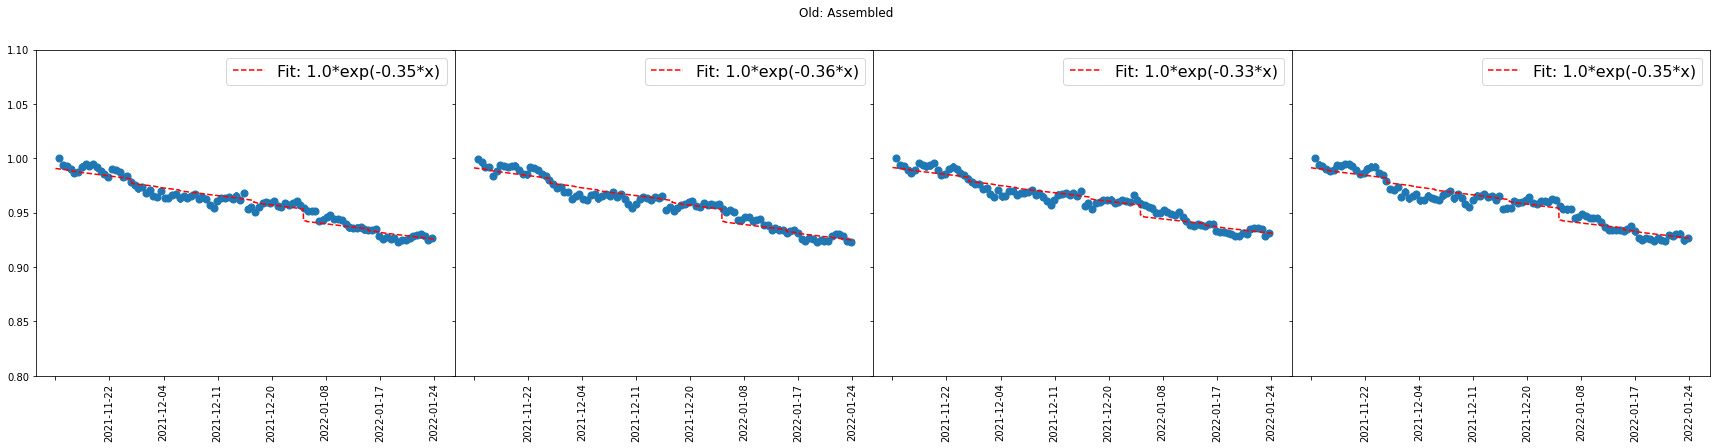

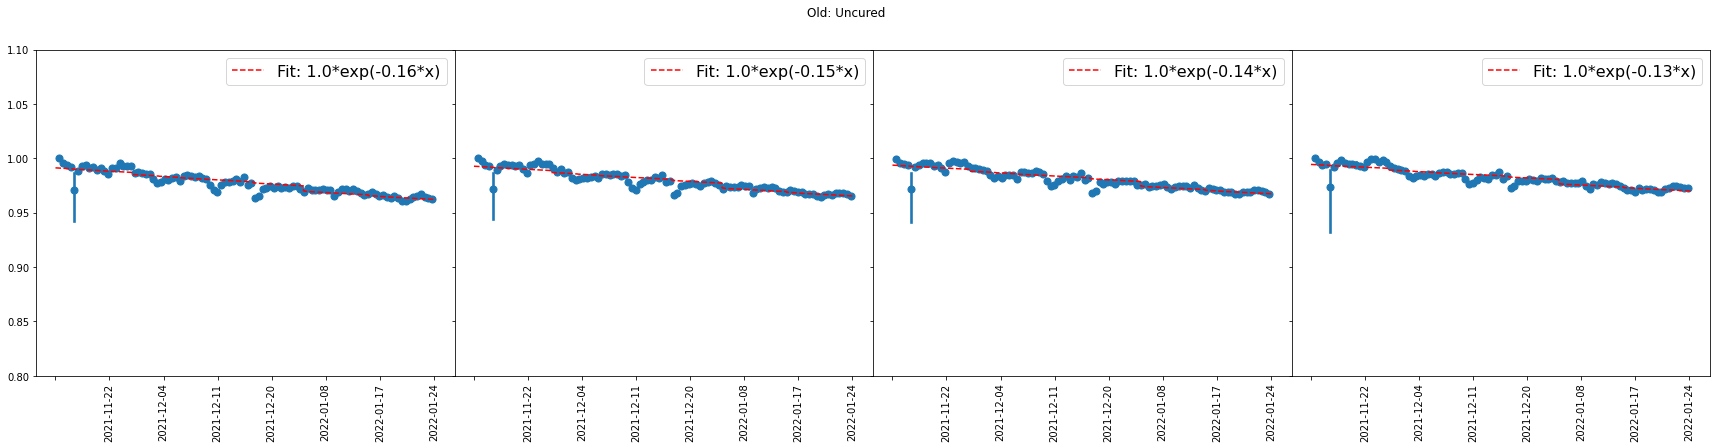

In [11]:
import seaborn as sns

data_['date_f'] = pd.factorize(data_['date'])[0] + 1
mapping = dict(zip(data_['date_f'], data_['date'].dt.date))

for chan in it.chain(range(0, 12), range(16, 20), range(60,64)):

  if(chan%4==0):
    fig, axs = plt.subplots(1,4, figsize=(30, 6), sharey=True);
    fig.subplots_adjust(wspace=0)

  y = data_[chan]
  y = y*np.exp(X*CS137_DECAY_RATE) #Cs137 decay rate: 2.3%/year
  popt, pcov = curve_fit(expo, X, y, p0=(1, 0.05))

  ax=axs[chan%4]
  fig.suptitle(getChanLabel(chan))
  sns.regplot(x=data_['date_f'], y=y, x_bins=100, fit_reg=None, ax=ax)
  ax.plot(data_['date_f'], expo(X, *popt), 'r--', label="Fit: " + str(round(popt[0], 1)) + "*exp("+str(-1*round(popt[1],2))+"*x)"); #fits an exponential to the function
  ax.set_ylabel('')
  ax.set_xlabel('')
  labels = pd.Series(ax.get_xticks()).map(mapping).fillna('')
  ax.set_xticklabels(labels)
  ax.legend(loc='upper right', prop={'size': 16})
  ax.set_ylim(0.8,1.1)
  ax.tick_params(axis='x', labelrotation = 90);


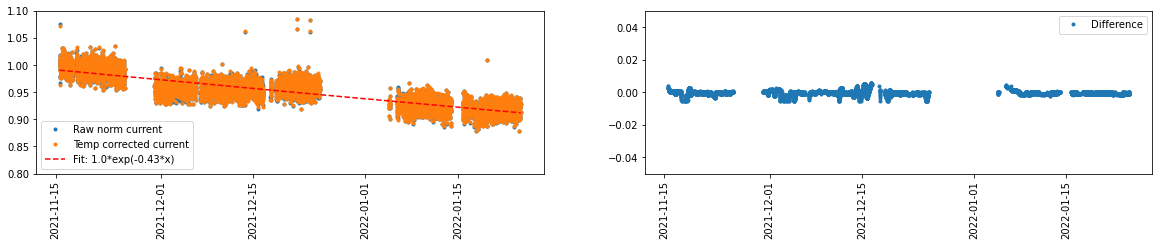

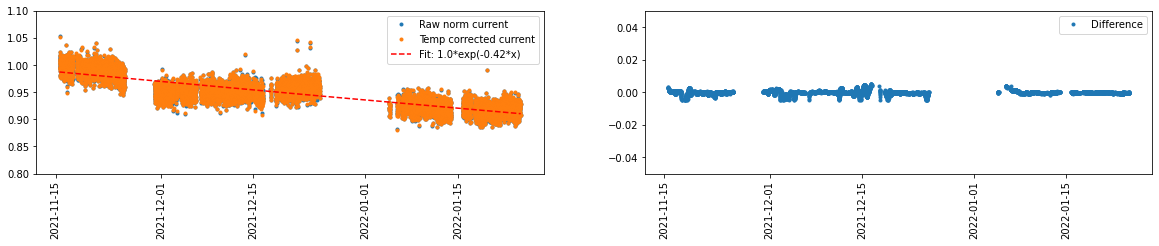

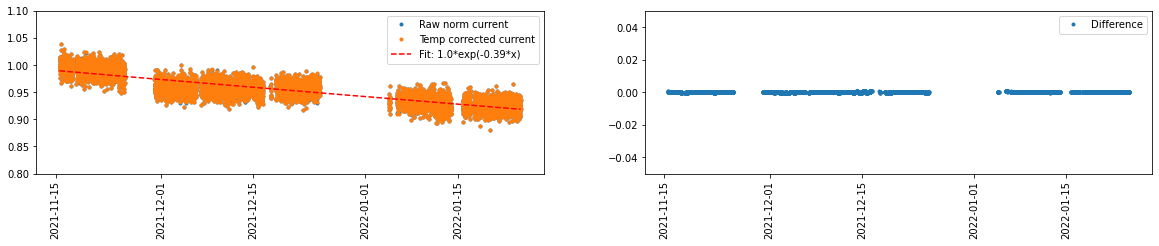

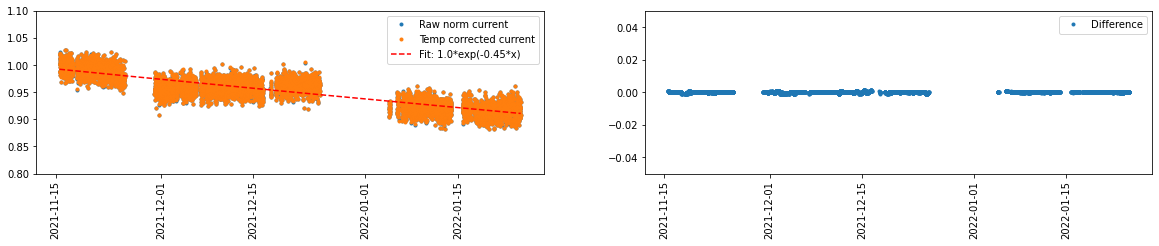

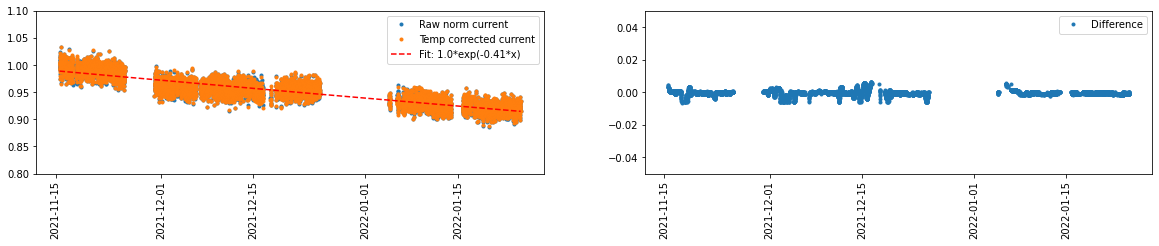

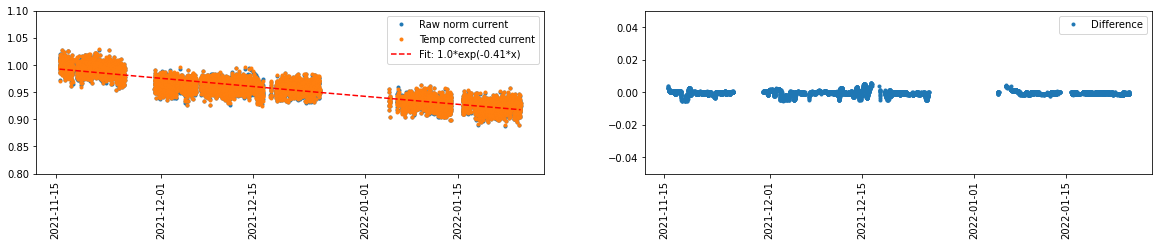

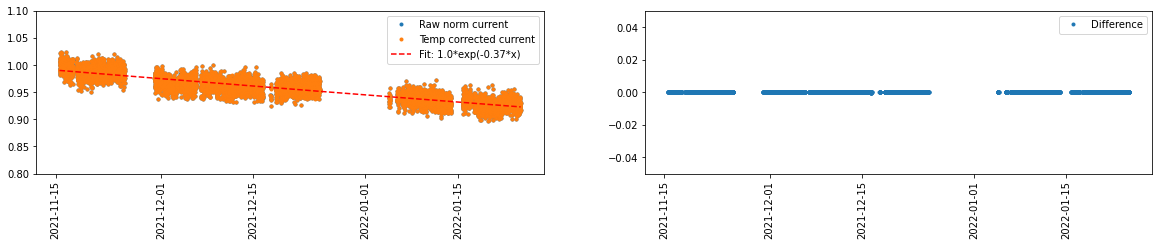

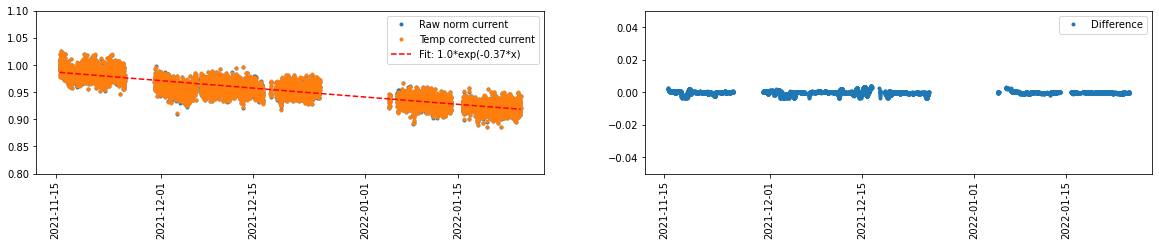

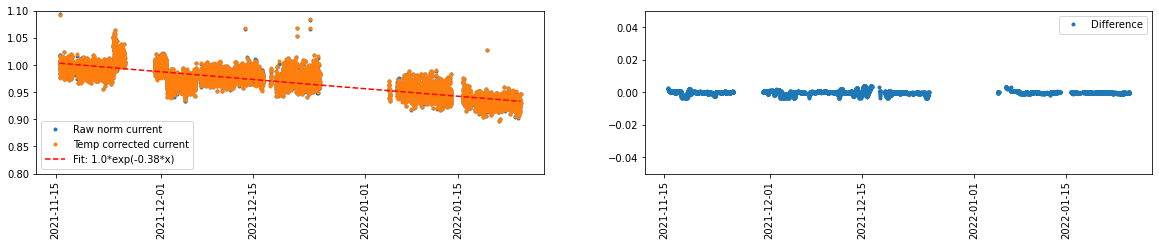

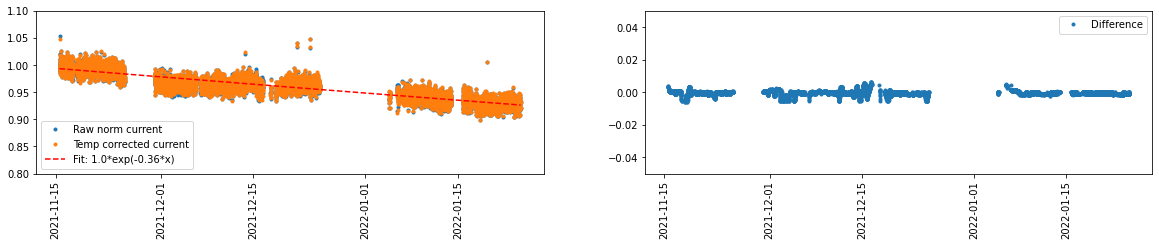

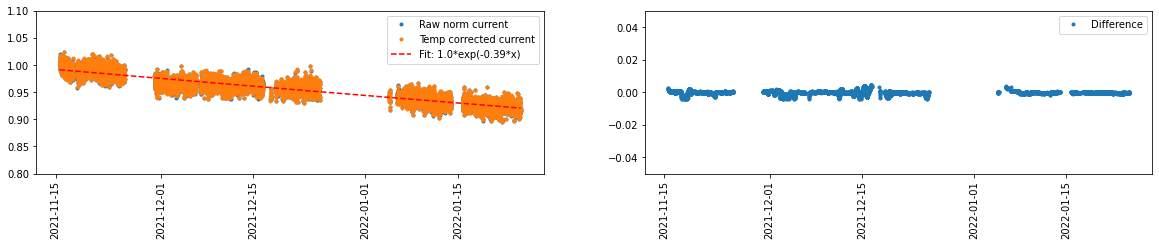

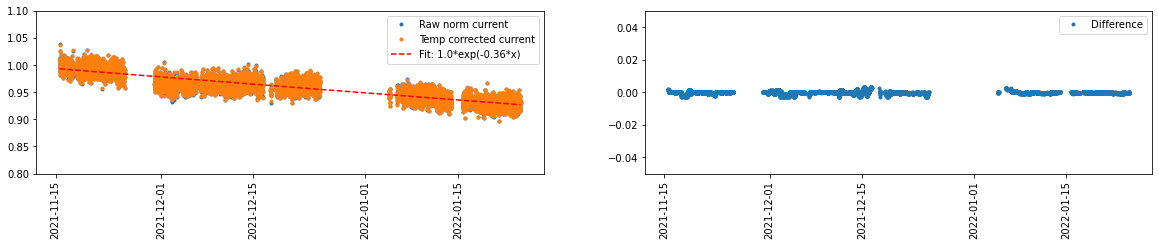

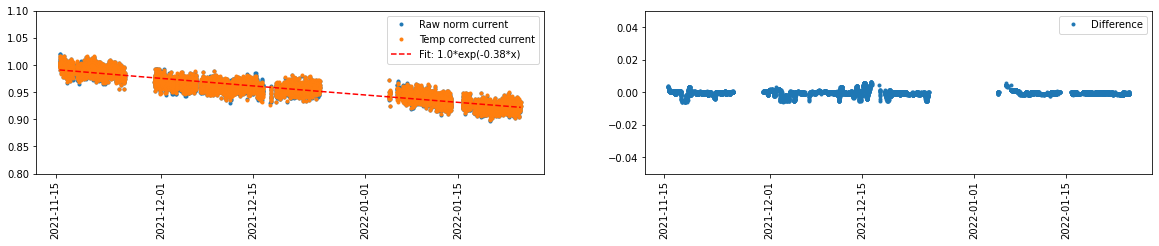

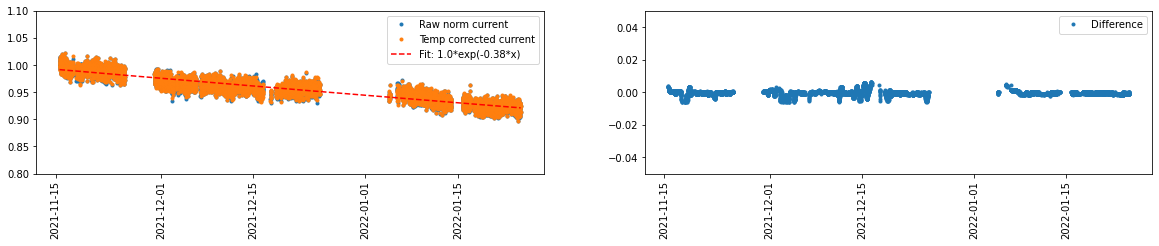

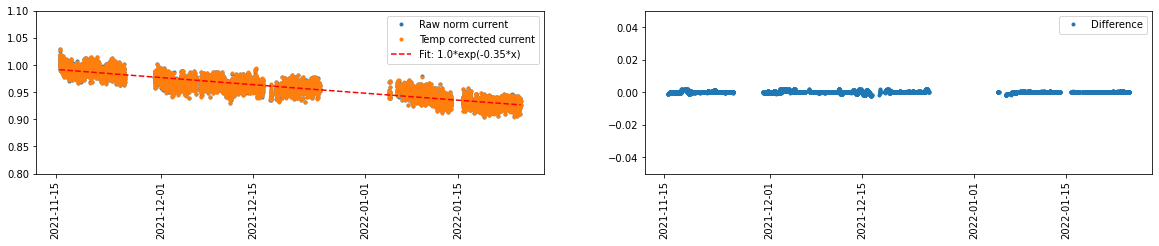

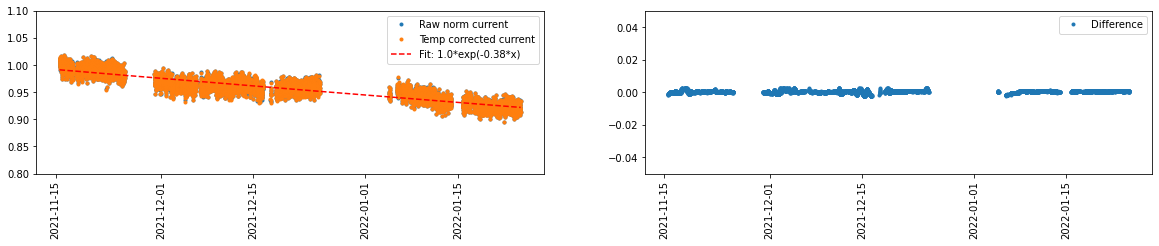

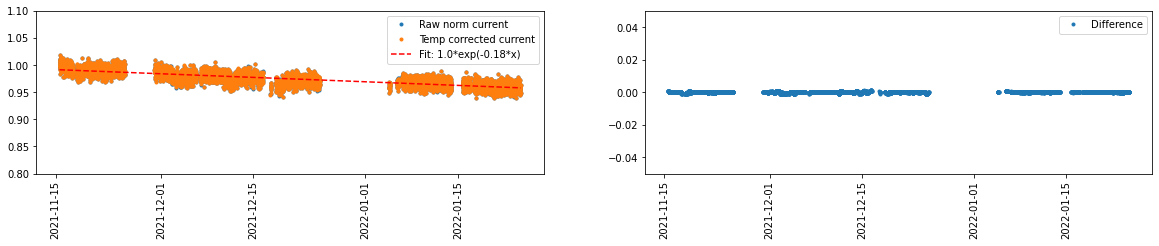

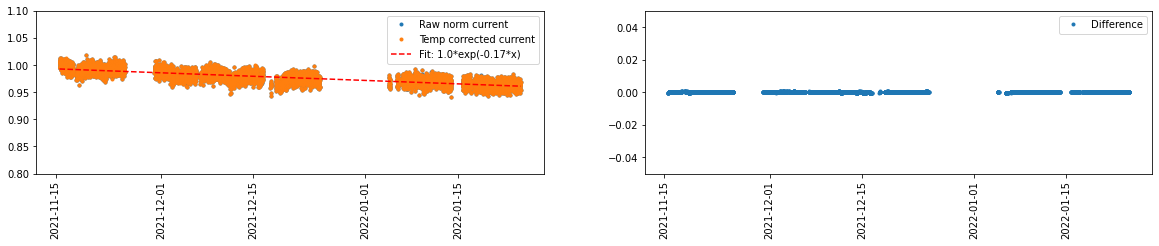

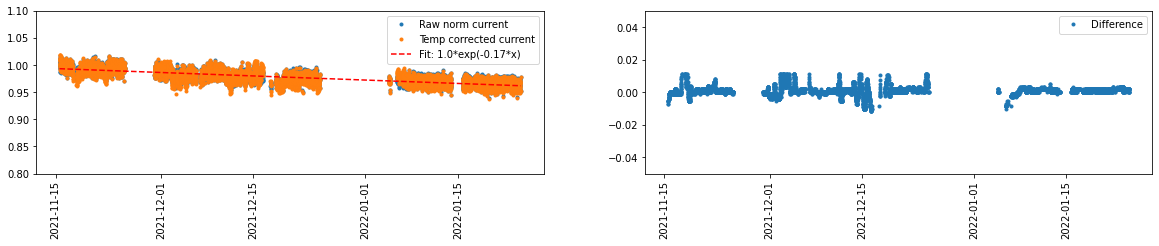

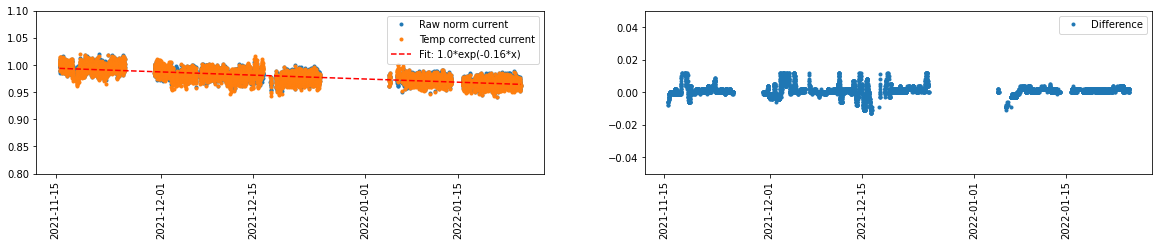

In [12]:
for chan in it.chain(range(0, 12), range(16, 20), range(60,64)):

  fig, axs = plt.subplots(1,2, figsize=(20, 3));
  axs[0].plot(data_.date, data_[chan], '.', label='Raw norm current')

  y =  data_[chan]*(calib_df.query('chan==%d'%chan)['const'].to_numpy() + data_['temp']*calib_df.query('chan==%d'%chan)['slope'].to_numpy())
  axs[0].plot(data_.date, y, '.', label='Temp corrected current')
  axs[0].set_ylim(0.8, 1.1)
  axs[0].tick_params(axis='x', labelrotation = 90);
  popt, pcov = curve_fit(expo, X, y, p0=(1, 0.05))
  axs[0].plot(data_.date, expo(X, *popt), 'r--', label="Fit: " + str(round(popt[0], 1)) + "*exp("+str(-1*round(popt[1],2))+"*x)"); #fits an exponential to the function
  axs[0].legend()


  axs[1].plot(data_.date, data_[chan] - data_[chan]*(calib_df.query('chan==%d'%chan)['const'].to_numpy() + data_['temp']*calib_df.query('chan==%d'%chan)['slope'].to_numpy()), '.', label='Difference')
  axs[1].set_ylim(-0.05, 0.05)
  axs[1].legend()
  axs[1].tick_params(axis='x', labelrotation = 90);


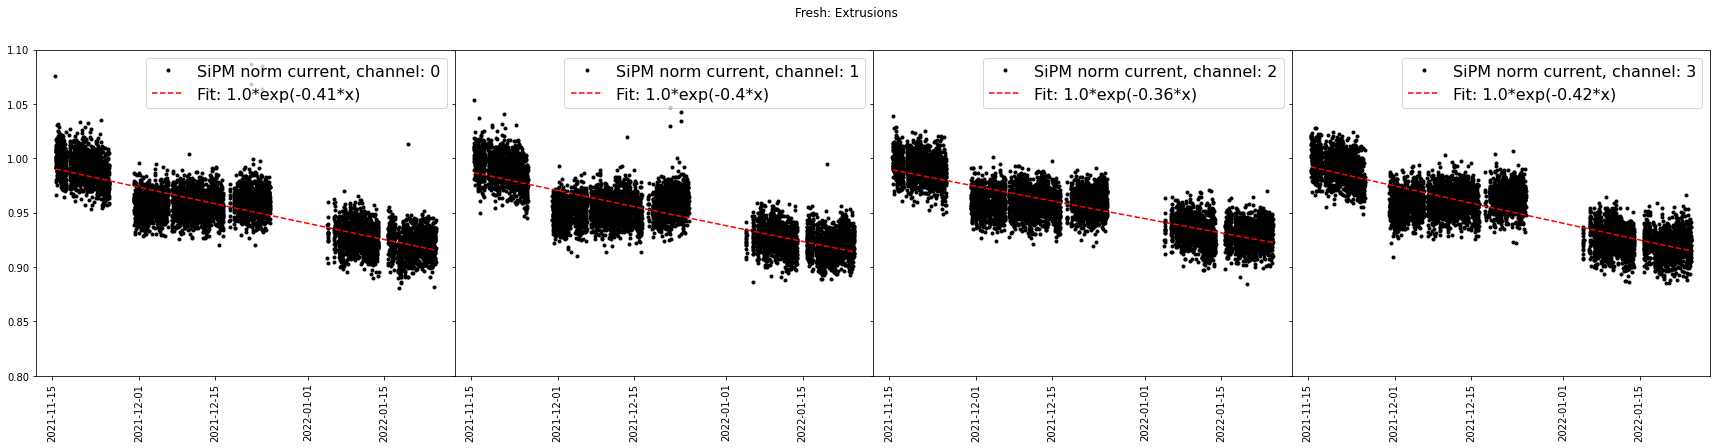

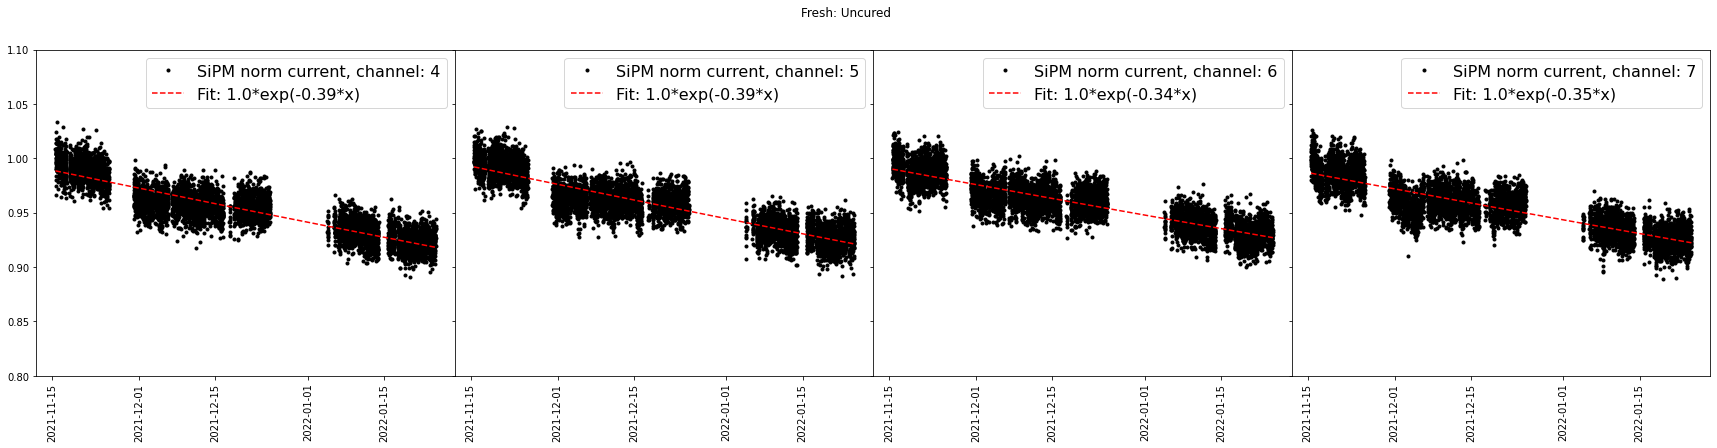

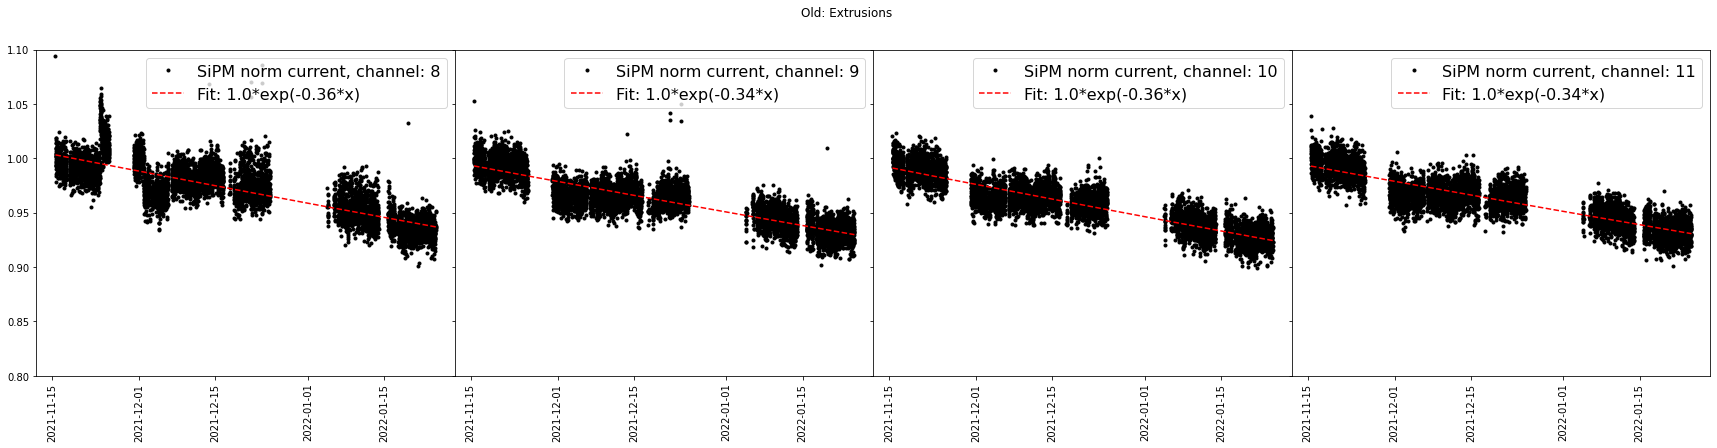

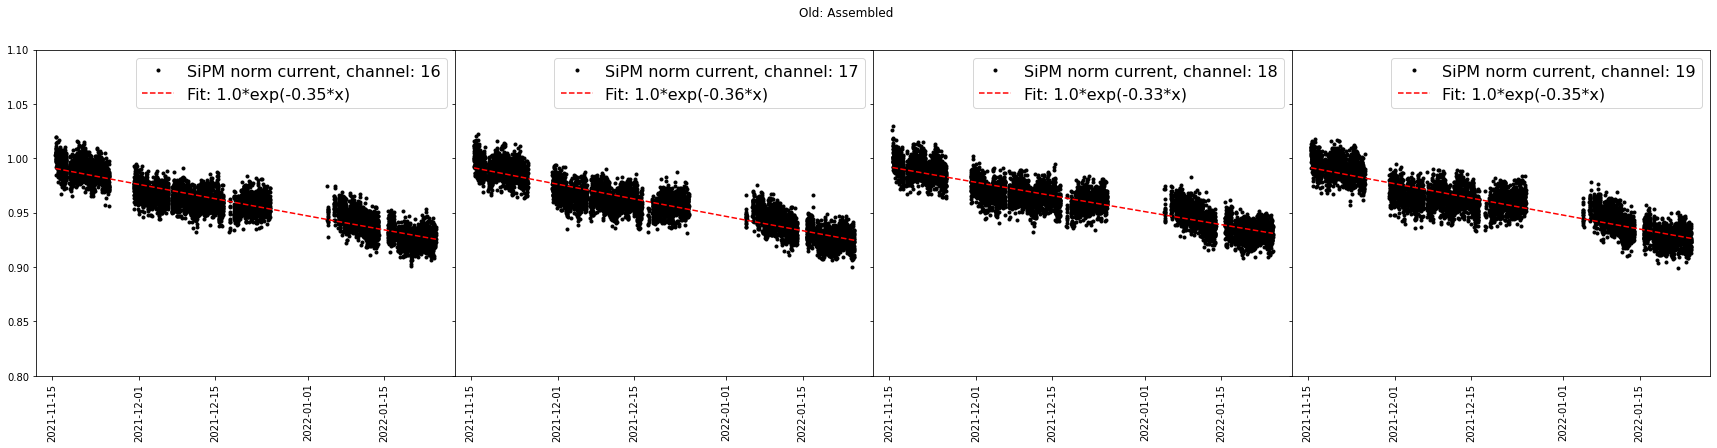

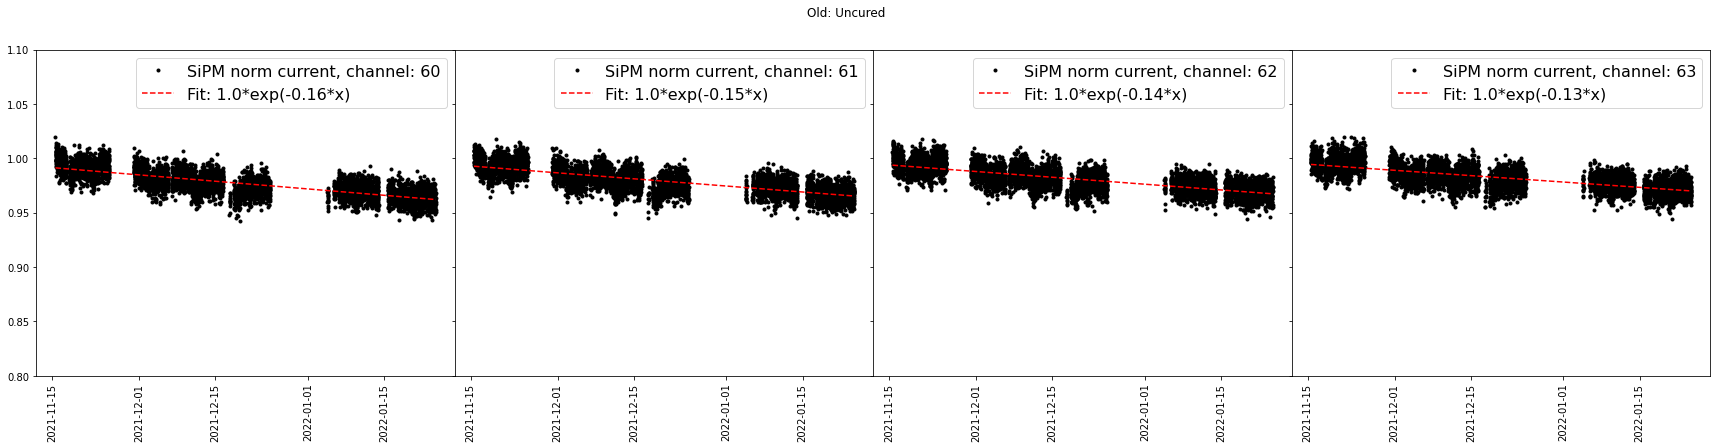

In [13]:
label = ''
for chan in it.chain(range(0, 12), range(16, 20), range(60,64)):
  
  y = data_[chan]
  y = y*np.exp(X*CS137_DECAY_RATE) #Cs137 decay rate: 2.3%/year
  popt, pcov = curve_fit(expo, X, y, p0=(1, 0.05))

  if(chan%4==0):
    fig, axs = plt.subplots(1,4, figsize=(30, 6), sharey=True);
    fig.subplots_adjust(wspace=0)
  fig.suptitle(getChanLabel(chan))
  axs[chan%4].plot(data_.date, y, 'k.', label="SiPM norm current, channel: %d"%chan);
  axs[chan%4].plot(data_.date, expo(X, *popt), 'r--', label="Fit: " + str(round(popt[0], 1)) + "*exp("+str(-1*round(popt[1],2))+"*x)"); #fits an exponential to the function
  axs[chan%4].legend(loc='upper right', prop={'size': 16})
  axs[chan%4].set_ylim(0.8,1.1);
  axs[chan%4].tick_params(axis='x', labelrotation = 90);

Text(0.5, 0, 'Temp [C]')

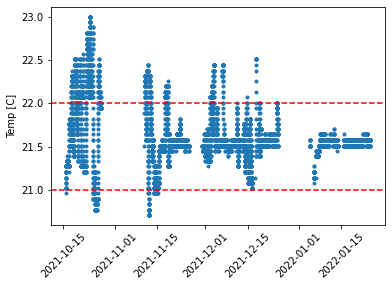

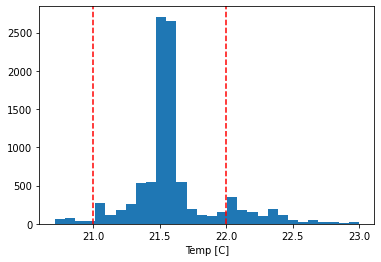

In [14]:
plt.plot(data.date, data.temp, '.', label='Temp [C]')
plt.axhline(y=MIN_TEMP, color='r', linestyle='--')
plt.axhline(y=MAX_TEMP, color='r', linestyle='--')
plt.xticks(rotation = 45);
plt.ylabel('Temp [C]')

plt.figure()
plt.hist(data.temp, bins=30, label='Temp [C]');
plt.axvline(x=MIN_TEMP, color='r', linestyle='--')
plt.axvline(x=MAX_TEMP, color='r', linestyle='--')
plt.xlabel('Temp [C]')

In [15]:
data[['date', 'source', 0, 'temp']].tail()

,date,source,0,temp
9827,2022-01-24 11:49:00,1,0.5863,21.58
9828,2022-01-24 12:09:00,1,0.5831,21.58
9829,2022-01-24 12:18:00,1,0.5683,21.51
9830,2022-01-24 12:47:00,1,0.5815,21.51
9831,2022-01-24 12:56:00,1,0.5744,21.51
